In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install japanize_matplotlib
! pip install xfeat
! pip install category-encoders

     |████████████████████████████████| 4.1 MB 4.9 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120274 sha256=590adccd7d9a46da53bbe366d6cbd0d966928873c21d830b7b51cc7ed0f6d9a3
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib
     |████████████████████████████████| 302 kB 6.0 MB/s 
     |████████████████████████████████| 80 kB 8.0 MB/s 
     |████████████████████████████████| 208 kB 67.9 MB/s 
     |████████████████████████████████| 75 kB 3.9 MB/s 
     |████████████████████████████████| 49 kB 5.7 MB/s 
     |████████████████████████████████| 111 kB 44.1 MB/s 
     |████████████████████████████████| 144 kB 56.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=80aae1cae59914bc02f7def86cd7b9571ebf367fd1e2740fcb87cc08e627ceb7
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b0

In [ ]:
## import module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from matplotlib_venn import venn2
import os
from statistics import mode
from scipy.optimize import minimize, minimize_scalar
from scipy.misc import derivative

import missingno as msno

from IPython.display import Image

from sklearn.model_selection import KFold, StratifiedKFold
import category_encoders as ce
from xfeat import (SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, 
                   ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer)
from sklearn import preprocessing
from time import time
from contextlib import contextmanager
import lightgbm as lgb

from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
class CFG:
  exp = "exp09"
  seed = 71
  fold = 10

CONFIG = CFG()

In [ ]:
input_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/data/"
output_dir = "/content/drive/MyDrive/KMI_ddbrothers/hirahara/output/"

# データフレームの形状変換

In [ ]:
pd.set_option("display.max_colwidth", 300)

# Import file
df1 = pd.read_csv(input_dir + "gi_train_mm10.csv")
df2 = pd.read_csv(input_dir + "gi_train_mm11.csv")
df_test = pd.read_csv(input_dir + "gi_test.csv")
item_df = pd.read_csv(output_dir+"item_df.csv",index_col=0)
sample_submit = pd.read_csv(input_dir + "gi_sample_submit.csv")
df_train = pd.concat([df1,df2]).reset_index(drop=True)

df_train = df_train[~df_train.customer_id.isnull()].reset_index()

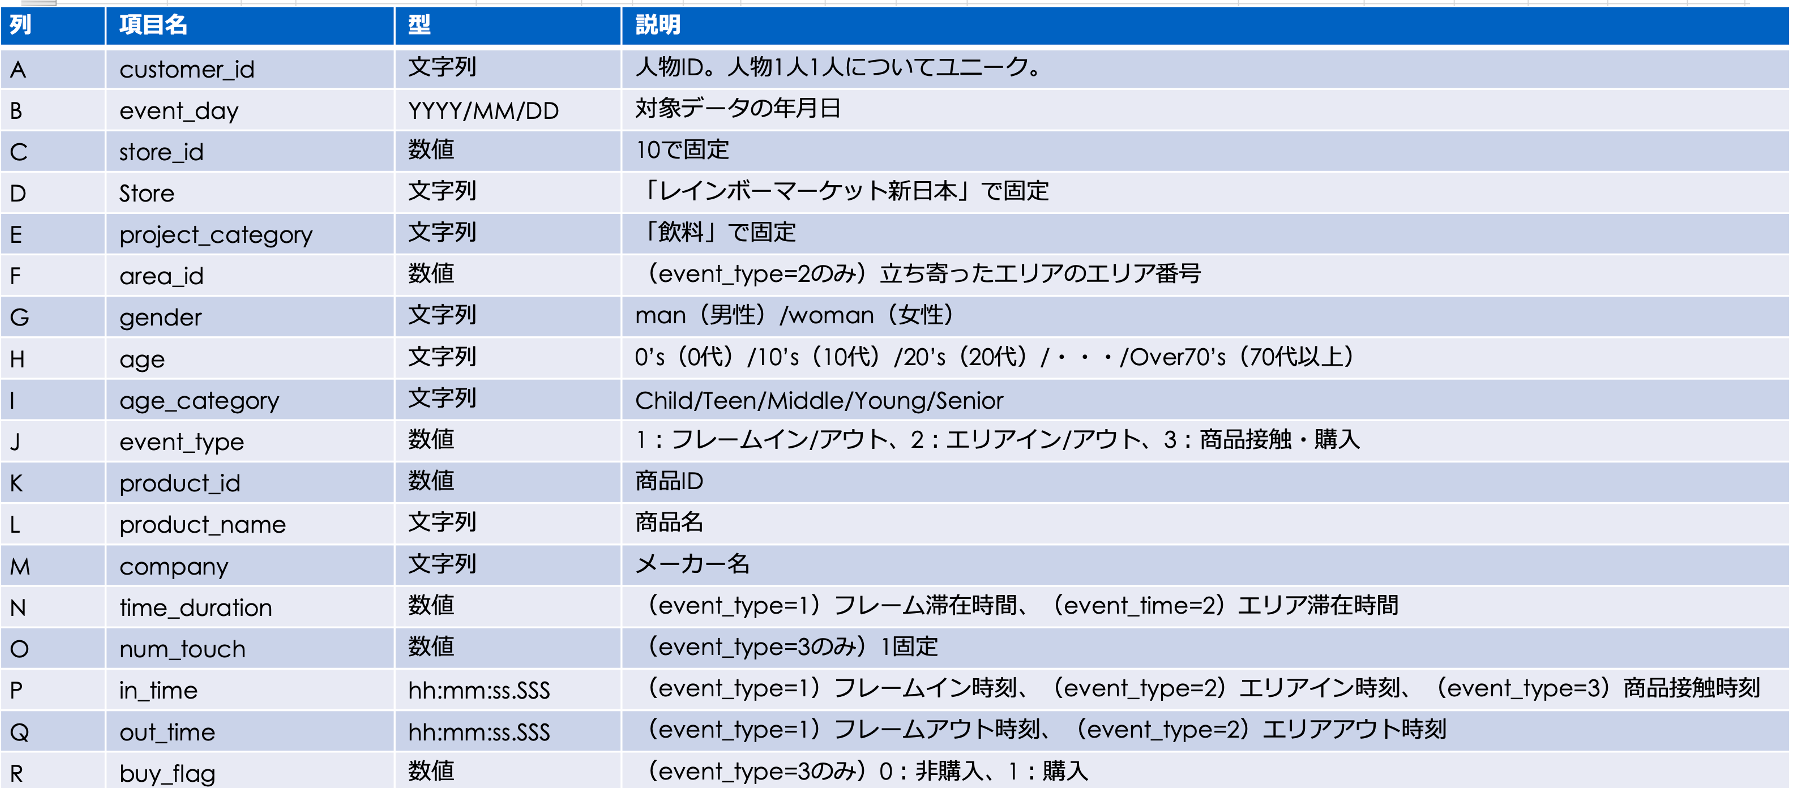

In [ ]:
Image(input_dir + "description.png", width = 1000)

In [ ]:
df_train = df_train[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch', 
                     'in_time',
                     'out_time', 
                     'buy_flag']]

df_test = df_test[['customer_id',
                     'event_day', 
                     #'store_id', 
                     #'store',
                     #'project_category',
                     'area_id',
                     'gender', 
                     'age', 
                     'age_category',
                     'event_type',
                     'product_id', 
                     'product_name', 
                     'company', 
                     'time_duration',
                     'num_touch',
                     'in_time',
                     'out_time']]

## データフレームへの時間特徴量の追加

In [ ]:
df_train[df_train.customer_id=="20201101-120054"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag
17691,20201101-120054,2020/11/1,NaN,man,30's,Young,1,NaN,NaN,NaN,28.4,NaN,21:38:07.200,21:38:35.600,NaN
18904,20201101-120054,2020/11/1,1.0,man,30's,Young,2,NaN,NaN,NaN,11.2,NaN,21:38:15.600,21:38:26.800,NaN
20272,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,21:38:20.200,NaN,0.0
20273,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,21:38:20.800,NaN,0.0
20274,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,21:38:21.200,NaN,1.0


In [ ]:
df_train =df_train.copy()
df_test =df_test.copy()

df_train["in_time"]=pd.to_datetime(df_train["in_time"])
df_train["out_time"]=pd.to_datetime(df_train["out_time"])
df_test["in_time"]=pd.to_datetime(df_test["in_time"])
df_test["out_time"]=pd.to_datetime(df_test["out_time"])

In [ ]:
df_train1 = df_train[df_train.event_type ==1].reset_index(drop=True)
df_train2 = df_train[df_train.event_type ==2].reset_index(drop=True)
df_train3 = df_train[df_train.event_type ==3].reset_index(drop=True)

df_test1 = df_test[df_test.event_type ==1].reset_index(drop=True)
df_test2 = df_test[df_test.event_type ==2].reset_index(drop=True)
df_test3 = df_test[df_test.event_type ==3].reset_index(drop=True)

In [ ]:
len(df_train3)

7002

In [ ]:
df_train4 = pd.merge(df_train3,df_train1[["customer_id","in_time","out_time"]],on="customer_id")
df_train4=df_train4.rename(columns={"in_time_x":"in_time_3","out_time_x":"out_time_3","in_time_y":"in_time_1","out_time_y":"out_time_1"})
df_train4 = pd.merge(df_train4,df_train2[["customer_id","in_time","out_time"]],on="customer_id")
df_train4=df_train4.rename(columns={"in_time":"in_time_2","out_time":"out_time_2"})


df_train4["1in_3in"]=df_train4["in_time_3"]-df_train4["in_time_1"]
df_train4["1in_3in"] = df_train4["1in_3in"].apply(lambda x: x.seconds)
df_train4["3in_1out"]=df_train4["out_time_1"]-df_train4["in_time_3"]
df_train4["3in_1out"] = df_train4["3in_1out"].apply(lambda x: x.seconds)
df_train4["3in_2in"]=df_train4["in_time_3"]-df_train4["in_time_2"]
df_train4["3in_2in"] = df_train4["3in_2in"].apply(lambda x: x.seconds)
df_train4["3in_2out"]=df_train4["out_time_2"]-df_train4["in_time_3"]
df_train4["3in_2out"] = df_train4["3in_2out"].apply(lambda x: x.seconds)

df_train4

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time_3,out_time_3,buy_flag,in_time_1,out_time_1,in_time_2,out_time_2,1in_3in,3in_1out,3in_2in,3in_2out
0,20201026-010001,2020/10/26,NaN,woman,30's,Young,3,1.0,トラディショナル緑茶525ml,クオリティー,0.0,1.0,2021-09-24 08:01:51.400,NaT,1.0,2021-09-24 08:01:50.200,2021-09-24 08:01:56.400,2021-09-24 08:01:50.200,2021-09-24 08:01:56.400,1,5,1,5
1,20201026-010001,2020/10/26,NaN,woman,30's,Young,3,1.0,トラディショナル緑茶525ml,クオリティー,0.0,1.0,2021-09-24 08:01:53.600,NaT,1.0,2021-09-24 08:01:50.200,2021-09-24 08:01:56.400,2021-09-24 08:01:50.200,2021-09-24 08:01:56.400,3,2,3,2
2,20201026-010002,2020/10/26,NaN,man,50's,Middle,3,6.0,クリアブラウン525ml,クオリティー,0.0,1.0,2021-09-24 08:02:50.400,NaT,1.0,2021-09-24 08:02:43.600,2021-09-24 08:02:57.200,2021-09-24 08:02:49.400,2021-09-24 08:02:57.200,6,6,1,6
3,20201026-010002,2020/10/26,NaN,man,50's,Middle,3,1.0,トラディショナル緑茶525ml,クオリティー,0.0,1.0,2021-09-24 08:02:54.200,NaT,1.0,2021-09-24 08:02:43.600,2021-09-24 08:02:57.200,2021-09-24 08:02:49.400,2021-09-24 08:02:57.200,10,3,4,3
4,20201026-010003,2020/10/26,NaN,man,50's,Middle,3,42.0,桃の世界410ml,フューチャー,0.0,1.0,2021-09-24 08:03:00.400,NaT,1.0,2021-09-24 08:02:57.800,2021-09-24 08:03:12.000,2021-09-24 08:02:58.000,2021-09-24 08:03:12.000,2,11,2,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13176,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,2021-09-24 21:38:20.200,NaT,0.0,2021-09-24 21:38:07.200,2021-09-24 21:38:35.600,2021-09-24 21:38:15.600,2021-09-24 21:38:26.800,13,15,4,6
13177,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-24 21:38:20.800,NaT,0.0,2021-09-24 21:38:07.200,2021-09-24 21:38:35.600,2021-09-24 21:38:15.600,2021-09-24 21:38:26.800,13,14,5,6
13178,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-24 21:38:21.200,NaT,1.0,2021-09-24 21:38:07.200,2021-09-24 21:38:35.600,2021-09-24 21:38:15.600,2021-09-24 21:38:26.800,14,14,5,5
13179,20201101-120055,2020/11/1,NaN,woman,30's,Young,3,4.0,ジャパンスプラッシュ500ml,クオリティー,0.0,1.0,2021-09-24 21:39:33.800,NaT,0.0,2021-09-24 21:39:27.400,2021-09-24 21:39:41.400,2021-09-24 21:39:28.000,2021-09-24 21:39:41.000,6,7,5,7


In [ ]:
df_train4[df_train4.customer_id=="20201101-120054"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time_3,out_time_3,buy_flag,in_time_1,out_time_1,in_time_2,out_time_2
13176,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,2021-09-24 21:38:20.200,NaT,0.0,2021-09-24 21:38:07.200,2021-09-24 21:38:35.600,2021-09-24 21:38:15.600,2021-09-24 21:38:26.800
13177,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-24 21:38:20.800,NaT,0.0,2021-09-24 21:38:07.200,2021-09-24 21:38:35.600,2021-09-24 21:38:15.600,2021-09-24 21:38:26.800
13178,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-24 21:38:21.200,NaT,1.0,2021-09-24 21:38:07.200,2021-09-24 21:38:35.600,2021-09-24 21:38:15.600,2021-09-24 21:38:26.800


In [ ]:
df_train.to_pickle(input_dir + "train_rev.pkl")
df_test.to_pickle(input_dir + "test_rev.pkl")

# 処理済みデータ読み込み

In [ ]:
df_train = pd.read_pickle(input_dir + "train_rev.pkl")
df_test = pd.read_pickle(input_dir + "test_rev.pkl")

In [ ]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,area_id,gender,age,age_category,event_type,product_id,product_name,company,time_duration,num_touch,in_time,out_time,buy_flag,1in_3in,3in_1out
17691,20201101-120054,2020/11/1,NaN,man,30's,Young,1,NaN,NaN,NaN,28.4,NaN,2021-09-21 21:38:07.200,2021-09-21 21:38:35.600,NaN,0,28
18904,20201101-120054,2020/11/1,1.0,man,30's,Young,2,NaN,NaN,NaN,11.2,NaN,2021-09-21 21:38:15.600,2021-09-21 21:38:26.800,NaN,8,20
20272,20201101-120054,2020/11/1,NaN,man,30's,Young,3,94.0,うるうるグリーンティー525ml,エターナル,0.0,1.0,2021-09-21 21:38:20.200,NaT,0.0,13,15
20273,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-21 21:38:20.800,NaT,0.0,13,14
20274,20201101-120054,2020/11/1,NaN,man,30's,Young,3,27.0,新緑の丘525ml,フューチャー,0.0,1.0,2021-09-21 21:38:21.200,NaT,1.0,14,14


In [ ]:
df_test_0=df_test[df_test.event_type !=3].reset_index(drop=True)

In [ ]:
df_train1 = df_train[df_train.event_type ==1].reset_index(drop=True)
df_train2 = df_train[df_train.event_type ==2].reset_index(drop=True)
df_train3 = df_train[df_train.event_type ==3].reset_index(drop=True)

df_test1 = df_test[df_test.event_type ==1].reset_index(drop=True)
df_test2 = df_test[df_test.event_type ==2].reset_index(drop=True)
df_test3 = df_test[df_test.event_type ==3].reset_index(drop=True)

## Customer_IDごとの各特徴量の整理

In [ ]:
# base
df_train3 = df_train3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])
df_test3 = df_test3.drop(columns=["event_type","product_id","time_duration","num_touch","in_time","out_time","area_id"])

#shopper frame time
df_frametime_train=df_train1[["customer_id","time_duration","in_time"]].drop_duplicates()
df_frametime_test=df_test1[["customer_id","time_duration","in_time"]].drop_duplicates()


In [ ]:
df_train = pd.merge(df_train3,df_frametime_train,on="customer_id")
df_train = pd.merge(df_train,item_df,on="product_name")
df_train = df_train.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration', 'in_time', 'buy_flag'])

df_test = pd.merge(df_test3,df_frametime_test,on="customer_id")
df_test = pd.merge(df_test,item_df,on="product_name")
df_test = df_test.reindex(columns=['customer_id', 'event_day', 'gender', 'age', 'age_category','product_name', 'company', 'area_id', '1in_3in', '3in_1out','time_duration', 'in_time'])

In [ ]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,1,5,6.2,2021-09-21 08:01:50.200,1.0
1,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,3,2,6.2,2021-09-21 08:01:50.200,1.0
2,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,クオリティー,1.0,10,3,13.6,2021-09-21 08:02:43.600,1.0
3,20201026-010017,2020/10/26,man,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,8,49,58.4,2021-09-21 08:19:15.000,0.0
4,20201026-010017,2020/10/26,man,30's,Young,トラディショナル緑茶525ml,クオリティー,1.0,10,48,58.4,2021-09-21 08:19:15.000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,20201101-090008,2020/11/1,man,30's,Young,本当のオレンジ490ml,フューチャー,3.0,22,101,124.0,2021-09-21 17:02:30.400,0.0
6998,20201101-100059,2020/11/1,man,60's,Senior,本当のオレンジ490ml,フューチャー,3.0,85,61,146.6,2021-09-21 18:21:02.200,1.0
6999,20201101-110130,2020/11/1,man,30's,Young,本当のオレンジ490ml,フューチャー,3.0,11,31,43.0,2021-09-21 20:27:12.200,0.0
7000,20201101-110130,2020/11/1,man,30's,Young,本当のオレンジ490ml,フューチャー,3.0,28,15,43.0,2021-09-21 20:27:12.200,0.0


In [ ]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration,in_time
0,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,8,11,19.8,2021-09-21 08:07:13.000
1,20201026-010006,2020/10/26,man,40's,Middle,クリアブラウン525ml,クオリティー,1.0,10,9,19.8,2021-09-21 08:07:13.000
2,20201026-010012,2020/10/26,woman,20's,Young,クリアブラウン525ml,クオリティー,1.0,7,7,15.2,2021-09-21 08:12:40.600
3,20201026-010070,2020/10/26,woman,30's,Young,クリアブラウン525ml,クオリティー,1.0,29,16,45.0,2021-09-21 09:14:56.400
4,20201026-010070,2020/10/26,woman,30's,Young,クリアブラウン525ml,クオリティー,1.0,36,8,45.0,2021-09-21 09:14:56.400
...,...,...,...,...,...,...,...,...,...,...,...,...
4417,20201101-070207,2020/11/1,man,40's,Middle,ちょこっとファイバー100ml,トップモード,3.0,30,53,83.4,2021-09-21 15:58:10.200
4418,20201101-070207,2020/11/1,man,40's,Middle,ちょこっとファイバー100ml,トップモード,3.0,33,50,83.4,2021-09-21 15:58:10.200
4419,20201101-070207,2020/11/1,man,40's,Middle,ちょこっとファイバー100ml,トップモード,3.0,35,48,83.4,2021-09-21 15:58:10.200
4420,20201101-070207,2020/11/1,man,40's,Middle,ちょこっとファイバー100ml,トップモード,3.0,37,46,83.4,2021-09-21 15:58:10.200


In [ ]:
df_train[df_train["customer_id"]=="20201101-120054"]

,customer_id,event_day,gender,age,age_category,product_name,company,area_id,1in_3in,3in_1out,time_duration,in_time,buy_flag
2850,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,13,14,28.4,2021-09-21 21:38:07.200,0.0
2851,20201101-120054,2020/11/1,man,30's,Young,新緑の丘525ml,フューチャー,1.0,14,14,28.4,2021-09-21 21:38:07.200,1.0
3206,20201101-120054,2020/11/1,man,30's,Young,うるうるグリーンティー525ml,エターナル,1.0,13,15,28.4,2021-09-21 21:38:07.200,0.0


In [ ]:
df_train.buy_flag.value_counts()

1.0    5189
0.0    1813
Name: buy_flag, dtype: int64

In [ ]:
df_train.area_id.value_counts()

1.0    2850
3.0    1673
5.0    1121
2.0     835
4.0     523
Name: area_id, dtype: int64

# 前処理

## 容量のカラム追加

In [ ]:
size_train=df_train.product_name.str.extract(r'(\d\d\d)').astype(int)
df_train.insert(loc = 6, column= 'size', value= size_train)

size_test=df_test.product_name.str.extract(r'(\d\d\d)').astype(int)
df_test.insert(loc = 6, column= 'size', value= size_test)

In [ ]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration,in_time,buy_flag
0,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,2021-09-21 08:01:50.200,1.0
1,20201026-010001,2020/10/26,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,2021-09-21 08:01:50.200,1.0
2,20201026-010002,2020/10/26,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,2021-09-21 08:02:43.600,1.0
3,20201026-010017,2020/10/26,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,8,49,58.4,2021-09-21 08:19:15.000,0.0
4,20201026-010017,2020/10/26,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,10,48,58.4,2021-09-21 08:19:15.000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,20201101-090008,2020/11/1,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,22,101,124.0,2021-09-21 17:02:30.400,0.0
6998,20201101-100059,2020/11/1,man,60's,Senior,本当のオレンジ490ml,490,フューチャー,3.0,85,61,146.6,2021-09-21 18:21:02.200,1.0
6999,20201101-110130,2020/11/1,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,11,31,43.0,2021-09-21 20:27:12.200,0.0
7000,20201101-110130,2020/11/1,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,28,15,43.0,2021-09-21 20:27:12.200,0.0


## 入時間の設定

In [ ]:
#エントリータイムの時間を抽出
df_train["in_time"] = pd.to_datetime(df_train["in_time"])
df_train["in_time"] = df_train["in_time"].apply(lambda x: x.hour)
df_train["in_time"] =df_train["in_time"].astype("object")

df_test["in_time"] = pd.to_datetime(df_test["in_time"])
df_test["in_time"] = df_test["in_time"].apply(lambda x: x.hour)
df_test["in_time"] =df_test["in_time"].astype("object")

#曜日
df_train["event_day"] = pd.to_datetime(df_train["event_day"])
df_train["event_day"] = df_train["event_day"].apply(lambda x: x.weekday())
df_train["event_day"] =df_train["event_day"].astype("object")

df_test["event_day"] = pd.to_datetime(df_test["event_day"])
df_test["event_day"] = df_test["event_day"].apply(lambda x: x.weekday())
df_test["event_day"] =df_test["event_day"].astype("object")

In [ ]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration,in_time,buy_flag
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,8,1.0
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,8,1.0
2,20201026-010002,0,man,50's,Middle,トラディショナル緑茶525ml,525,クオリティー,1.0,10,3,13.6,8,1.0
3,20201026-010017,0,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,8,49,58.4,8,0.0
4,20201026-010017,0,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,10,48,58.4,8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,20201101-090008,6,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,22,101,124.0,17,0.0
6998,20201101-100059,6,man,60's,Senior,本当のオレンジ490ml,490,フューチャー,3.0,85,61,146.6,18,1.0
6999,20201101-110130,6,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,11,31,43.0,20,0.0
7000,20201101-110130,6,man,30's,Young,本当のオレンジ490ml,490,フューチャー,3.0,28,15,43.0,20,0.0


In [ ]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration,in_time
0,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8,11,19.8,8
1,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10,9,19.8,8
2,20201026-010012,0,woman,20's,Young,クリアブラウン525ml,525,クオリティー,1.0,7,7,15.2,8
3,20201026-010070,0,woman,30's,Young,クリアブラウン525ml,525,クオリティー,1.0,29,16,45.0,9
4,20201026-010070,0,woman,30's,Young,クリアブラウン525ml,525,クオリティー,1.0,36,8,45.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,20201101-070207,6,man,40's,Middle,ちょこっとファイバー100ml,100,トップモード,3.0,30,53,83.4,15
4418,20201101-070207,6,man,40's,Middle,ちょこっとファイバー100ml,100,トップモード,3.0,33,50,83.4,15
4419,20201101-070207,6,man,40's,Middle,ちょこっとファイバー100ml,100,トップモード,3.0,35,48,83.4,15
4420,20201101-070207,6,man,40's,Middle,ちょこっとファイバー100ml,100,トップモード,3.0,37,46,83.4,15


In [ ]:
df_train.groupby("age").count()

,customer_id,event_day,gender,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration,in_time,buy_flag
age,,,,,,,,,,,,,
0's,168,168,168,168,168,168,168,168,168,168,168,168,168
10's,583,583,583,583,583,583,583,583,583,583,583,583,583
20's,471,471,471,471,471,471,471,471,471,471,471,471,471
30's,1335,1335,1335,1335,1335,1335,1335,1335,1335,1335,1335,1335,1335
40's,1711,1711,1711,1711,1711,1711,1711,1711,1711,1711,1711,1711,1711
50's,1559,1559,1559,1559,1559,1559,1559,1559,1559,1559,1559,1559,1559
60's,941,941,941,941,941,941,941,941,941,941,941,941,941
Over70's,234,234,234,234,234,234,234,234,234,234,234,234,234


## ターゲットエンコーディング（購入率）

In [ ]:
def target_encoding(df,df_1,col):

  rate_df=df_train.groupby(col).buy_flag.sum().reset_index().set_index(col)
  count_df=df_train.groupby(col).customer_id.count().reset_index().set_index(col)

  cvr_df=pd.concat([rate_df,count_df],axis=1)
  cvr_df["cvr_rate_"+str(col)]=cvr_df["buy_flag"] / cvr_df["customer_id"]
  cvr_df=cvr_df.drop(columns=["buy_flag","customer_id"])
  cvr_df=cvr_df.reset_index()

  df = pd.merge(df,cvr_df,on=col)
  df_1 = pd.merge(df_1,cvr_df,on=col)

  return df,df_1

In [ ]:
target_cols=['event_day',
             'gender', 
             'age',
             'age_category',
             'product_name', 
             'size',
             'company',
             'area_id',
             'in_time']

for col in target_cols:
  df_train,df_test=target_encoding(df_train,df_test,col)

In [ ]:
df_train

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration,in_time,buy_flag,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time
0,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,1,5,6.2,8,1.0,0.760000,0.726811,0.779775,0.781285,0.900000,0.789057,0.836719,0.775439,0.768293
1,20201026-010001,0,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,3,2,6.2,8,1.0,0.760000,0.726811,0.779775,0.781285,0.900000,0.789057,0.836719,0.775439,0.768293
2,20201027-010002,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,17,2,19.4,8,1.0,0.703975,0.726811,0.779775,0.781285,0.900000,0.789057,0.836719,0.775439,0.768293
3,20201027-010049,1,woman,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,12,30,43.0,8,1.0,0.703975,0.726811,0.779775,0.781285,0.900000,0.789057,0.836719,0.775439,0.768293
4,20201026-010017,0,man,30's,Young,トラディショナル緑茶525ml,525,クオリティー,1.0,8,49,58.4,8,0.0,0.760000,0.757436,0.779775,0.781285,0.900000,0.789057,0.836719,0.775439,0.768293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6997,20201101-070065,6,man,40's,Middle,キッズアップル470ml,470,オールフロント,3.0,42,86,129.2,15,1.0,0.748175,0.757436,0.758036,0.780428,0.171717,0.331658,0.210145,0.650926,0.665138
6998,20201101-070078,6,woman,10's,Teen,キッズアップル470ml,470,オールフロント,3.0,11,12,23.2,15,0.0,0.748175,0.726811,0.457976,0.457976,0.171717,0.331658,0.210145,0.650926,0.665138
6999,20201027-030202,1,man,10's,Teen,キッズアップル470ml,470,オールフロント,3.0,5,34,40.2,15,0.0,0.703975,0.757436,0.457976,0.457976,0.171717,0.331658,0.210145,0.650926,0.665138
7000,20201027-030202,1,man,10's,Teen,キッズアップル470ml,470,オールフロント,3.0,5,34,40.2,15,0.0,0.703975,0.757436,0.457976,0.457976,0.171717,0.331658,0.210145,0.650926,0.665138


In [ ]:
df_test

,customer_id,event_day,gender,age,age_category,product_name,size,company,area_id,1in_3in,3in_1out,time_duration,in_time,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time
0,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8,11,19.8,8,0.760000,0.757436,0.758036,0.780428,0.929204,0.789057,0.836719,0.775439,0.768293
1,20201026-010006,0,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10,9,19.8,8,0.760000,0.757436,0.758036,0.780428,0.929204,0.789057,0.836719,0.775439,0.768293
2,20201029-010002,3,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10,4,14.4,8,0.779817,0.757436,0.758036,0.780428,0.929204,0.789057,0.836719,0.775439,0.768293
3,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,8,10,18.4,8,0.756952,0.757436,0.758036,0.780428,0.929204,0.789057,0.836719,0.775439,0.768293
4,20201030-010007,4,man,40's,Middle,クリアブラウン525ml,525,クオリティー,1.0,10,8,18.4,8,0.756952,0.757436,0.758036,0.780428,0.929204,0.789057,0.836719,0.775439,0.768293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,20201026-020259,0,man,30's,Young,電撃蜜柑410ml,410,レジェンド,3.0,45,38,84.2,13,0.760000,0.757436,0.779775,0.781285,0.515152,0.686747,0.515152,0.650926,0.780645
4418,20201026-020314,0,woman,40's,Middle,サンライズ470ml,470,オールフロント,3.0,16,9,25.0,13,0.760000,0.726811,0.758036,0.780428,0.307692,0.331658,0.210145,0.650926,0.780645
4419,20201026-020288,0,woman,30's,Young,サンライズ470ml,470,オールフロント,3.0,49,28,77.6,13,0.760000,0.726811,0.779775,0.781285,0.307692,0.331658,0.210145,0.650926,0.780645
4420,20201101-050053,6,woman,10's,Teen,サンライズ470ml,470,オールフロント,3.0,7,4,12.2,13,0.748175,0.726811,0.457976,0.457976,0.307692,0.331658,0.210145,0.650926,0.780645


## 滞在時間での切り捨て

In [ ]:
df_train.groupby("buy_flag").time_duration.mean()

buy_flag
0.0    89.614892
1.0    47.160763
Name: time_duration, dtype: float64

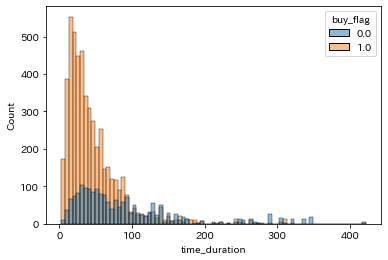

In [ ]:
sns.histplot(data=df_train, x="time_duration",hue="buy_flag")

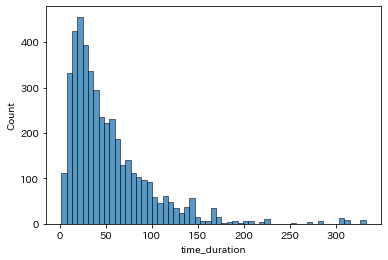

In [ ]:
sns.histplot(data=df_test, x="time_duration")

In [ ]:
df_train.buy_flag.value_counts()

1.0    5189
0.0    1813
Name: buy_flag, dtype: int64

In [ ]:
del_df_train = df_train[(df_train.time_duration > 100) & (df_train.buy_flag == 1)]

others_list=set(list(df_train.index)) ^ set(list(del_df_train.index)) 
df_train = df_train.loc[others_list].reset_index(drop=True)

In [ ]:
df_train.buy_flag.value_counts()

1.0    4773
0.0    1813
Name: buy_flag, dtype: int64

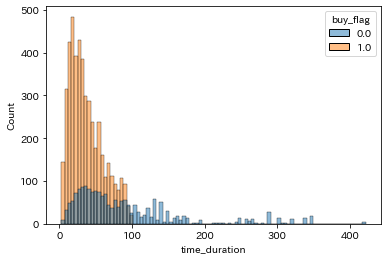

In [ ]:
sns.histplot(data=df_train, x="time_duration",hue="buy_flag")

## カテゴリーのエンコーディング

In [ ]:
# BaseBlock
class BaseBlock(object):
    def fit(self, input_df, y=None):
        return self.transform(input_df)
    
    def transform(self, input_df):
        raise NotImplementedError()
        
# CountEncoding
class CountEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        self.encoder = ce.CountEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.encoder.transform(input_df[self.cols]).add_prefix("CE_")

# OneHotEncoding
class OneHotEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OneHotEncoder(use_cat_names=True)
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OHE_")

# OrdinalEncoding
class OrdinalEncodingBlock(BaseBlock):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None
        
    def fit(self, input_df, y=None):
        self.encoder = ce.OrdinalEncoder()
        self.encoder.fit(input_df[self.cols])
        return self.transform(input_df[self.cols])
    
    def transform(self, input_df):
        return self.encoder.transform(input_df[self.cols]).add_prefix("OE_")

In [ ]:
def get_ce_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time',
            'product_name', 
            'size', 
            'company']
    encoder = CountEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df.astype(str))
    return output_df


def get_oe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time',
            'product_name', 
            'size', 
            'company']
    encoder = OrdinalEncodingBlock(cols = cols)
    output_df = encoder.fit(_input_df)
    return output_df

# not use
def get_ohe_features(input_df):
    _input_df = pd.concat([input_df], axis=1)
    cols = ['gender',
            'age',
            'age_category', 
            'event_day', 
            'area_id',
            'in_time',
            'product_name', 
            'size', 
            'company']
    encoder = OneHotEncodingBlock(cols=cols)
    output_df = encoder.fit(_input_df)
    return output_df

In [ ]:
df_train_ce=get_ce_features(df_train)
df_train_oe=get_oe_features(df_train)

df_test_ce=get_ce_features(df_test)
df_test_oe=get_oe_features(df_test)

In [ ]:
target = df_train["buy_flag"]
df_train_encoded = df_train.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time','product_name', 'size', 'company',"buy_flag"])
df_train_encoded = pd.concat([df_train_encoded,df_train_ce,df_train_oe],axis=1)
df_train_encoded["buy_flag"] = target 

df_test_encoded = df_test.drop(columns=['gender','age','age_category', 'event_day', 'area_id','in_time','product_name', 'size', 'company'])
df_test_encoded = pd.concat([df_test_encoded,df_test_ce,df_test_oe],axis=1)

In [ ]:
df_train_encoded

,customer_id,1in_3in,3in_1out,time_duration,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time,CE_gender,CE_age,CE_age_category,CE_event_day,CE_area_id,CE_in_time,CE_product_name,CE_size,CE_company,OE_gender,OE_age,OE_age_category,OE_event_day,OE_area_id,OE_in_time,OE_product_name,OE_size,OE_company,buy_flag
0,20201026-010001,1,5,6.2,0.760000,0.726811,0.779775,0.781285,0.900000,0.789057,0.836719,0.775439,0.768293,3508,1289,1749,823,2651,317,254,1311,1218,1,1,1,1,1.0,1,1,525,1,1.0
1,20201026-010001,3,2,6.2,0.760000,0.726811,0.779775,0.781285,0.900000,0.789057,0.836719,0.775439,0.768293,3508,1289,1749,823,2651,317,254,1311,1218,1,1,1,1,1.0,1,1,525,1,1.0
2,20201027-010002,17,2,19.4,0.703975,0.726811,0.779775,0.781285,0.900000,0.789057,0.836719,0.775439,0.768293,3508,1289,1749,914,2651,317,254,1311,1218,1,1,1,2,1.0,1,1,525,1,1.0
3,20201027-010049,12,30,43.0,0.703975,0.726811,0.779775,0.781285,0.900000,0.789057,0.836719,0.775439,0.768293,3508,1289,1749,914,2651,317,254,1311,1218,1,1,1,2,1.0,1,1,525,1,1.0
4,20201026-010017,8,49,58.4,0.760000,0.757436,0.779775,0.781285,0.900000,0.789057,0.836719,0.775439,0.768293,3078,1289,1749,823,2651,317,254,1311,1218,2,1,1,1,1.0,1,1,525,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6581,20201101-070012,11,45,57.2,0.748175,0.757436,0.805003,0.780428,0.171717,0.331658,0.210145,0.650926,0.665138,3078,1474,3057,1288,1565,601,96,193,133,2,2,2,7,3.0,14,78,470,12,1.0
6582,20201101-070078,11,12,23.2,0.748175,0.726811,0.457976,0.457976,0.171717,0.331658,0.210145,0.650926,0.665138,3508,547,547,1288,1565,601,96,193,133,1,7,4,7,3.0,14,78,470,12,0.0
6583,20201027-030202,5,34,40.2,0.703975,0.757436,0.457976,0.457976,0.171717,0.331658,0.210145,0.650926,0.665138,3078,547,547,914,1565,601,96,193,133,2,7,4,2,3.0,14,78,470,12,0.0
6584,20201027-030202,5,34,40.2,0.703975,0.757436,0.457976,0.457976,0.171717,0.331658,0.210145,0.650926,0.665138,3078,547,547,914,1565,601,96,193,133,2,7,4,2,3.0,14,78,470,12,0.0


In [ ]:
df_test_encoded

,customer_id,1in_3in,3in_1out,time_duration,cvr_rate_event_day,cvr_rate_gender,cvr_rate_age,cvr_rate_age_category,cvr_rate_product_name,cvr_rate_size,cvr_rate_company,cvr_rate_area_id,cvr_rate_in_time,CE_gender,CE_age,CE_age_category,CE_event_day,CE_area_id,CE_in_time,CE_product_name,CE_size,CE_company,OE_gender,OE_age,OE_age_category,OE_event_day,OE_area_id,OE_in_time,OE_product_name,OE_size,OE_company
0,20201026-010006,8,11,19.8,0.760000,0.757436,0.758036,0.780428,0.929204,0.789057,0.836719,0.775439,0.768293,2021,1124,1937,478,1776,208,51,851,737,1,1,1,1,1.0,1,1,525,1
1,20201026-010006,10,9,19.8,0.760000,0.757436,0.758036,0.780428,0.929204,0.789057,0.836719,0.775439,0.768293,2021,1124,1937,478,1776,208,51,851,737,1,1,1,1,1.0,1,1,525,1
2,20201029-010002,10,4,14.4,0.779817,0.757436,0.758036,0.780428,0.929204,0.789057,0.836719,0.775439,0.768293,2021,1124,1937,576,1776,208,51,851,737,1,1,1,2,1.0,1,1,525,1
3,20201030-010007,8,10,18.4,0.756952,0.757436,0.758036,0.780428,0.929204,0.789057,0.836719,0.775439,0.768293,2021,1124,1937,717,1776,208,51,851,737,1,1,1,3,1.0,1,1,525,1
4,20201030-010007,10,8,18.4,0.756952,0.757436,0.758036,0.780428,0.929204,0.789057,0.836719,0.775439,0.768293,2021,1124,1937,717,1776,208,51,851,737,1,1,1,3,1.0,1,1,525,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4417,20201026-020259,45,38,84.2,0.760000,0.757436,0.779775,0.781285,0.515152,0.686747,0.515152,0.650926,0.780645,2021,821,1175,478,1094,308,15,111,15,1,4,2,1,3.0,14,122,410,17
4418,20201026-020314,16,9,25.0,0.760000,0.726811,0.758036,0.780428,0.307692,0.331658,0.210145,0.650926,0.780645,2401,1124,1937,478,1094,308,27,135,79,2,1,1,1,3.0,14,68,470,12
4419,20201026-020288,49,28,77.6,0.760000,0.726811,0.779775,0.781285,0.307692,0.331658,0.210145,0.650926,0.780645,2401,821,1175,478,1094,308,27,135,79,2,4,2,1,3.0,14,68,470,12
4420,20201101-050053,7,4,12.2,0.748175,0.726811,0.457976,0.457976,0.307692,0.331658,0.210145,0.650926,0.780645,2401,297,297,766,1094,308,27,135,79,2,6,4,7,3.0,14,68,470,12


In [ ]:
df_train_encoded.to_pickle(input_dir + "train_enco.pkl")
df_test_encoded.to_pickle(input_dir + "test_enco.pkl")

# モデル作成　(Light GBM)

In [ ]:
@contextmanager
def timer(logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None):
    if prefix: format_str = str(prefix) + format_str
    if suffix: format_str = format_str + str(suffix)
    start = time()
    yield
    d = time() - start
    out_str = format_str.format(d)
    if logger:
        logger.info(out_str)
    else:
        print(out_str)

In [ ]:
def fit_lgbm(X, y, cv, params: dict=None, verbose: int=50):
    
    metric_func = roc_auc_score
    
    if params is None:
        params = {}

    models = []
    
    # training data の target と同じだけのゼロ配列を用意
    #oof_pred_df = pd.DataFrame(np.zeros_like(train_y, dtype=np.float)).rename(columns={0:"pred"})
    oof_pred_df = pd.DataFrame()

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # 交差検証 データセットを cv instance によって分割
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgb.LGBMClassifier(**params)

        # auc_score用のborder算出(単純にデータ数で閾値を決定）
        #border = y_valid.sum() / len(x_valid)

        #print(f"Best_Score_Border： {border}")

        with timer(prefix='fit fold={} '.format(i + 1)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=verbose,
                    verbose=verbose)
        
        # border で1, 0を分離するので、確率で算出する

        pred_i = clf.predict_proba(x_valid)[:, 1]
        pred_b = clf.predict(x_valid)

        #pred_i = np.where(pred_i < border, 0, 1)
        print(f'AUC {i} Score: {metric_func(y_valid, pred_i) :.4f}')
        
        oof_fold_df = pd.DataFrame(np.zeros_like(y_valid, dtype=np.float)).rename(columns={0:"pred"})
        oof_fold_df["id"]=idx_valid
        oof_fold_df["fold"]=i+1
        oof_fold_df["pred_prob"] = pred_i
        oof_fold_df["pred_bool"] = pred_b
        
        oof_pred_df=pd.concat([oof_pred_df,oof_fold_df],axis=0)
        
        
        models.append(clf)
        
    oof_pred_df=oof_pred_df.sort_values("id").reset_index(drop=True).set_index("id").reindex(['fold', 'y', 'pred_prob','pred_bool'], axis='columns')
    oof_pred_df["y"]=y
    score = metric_func(y, oof_pred_df["pred_prob"]) 
    print('FINISHED | AUC Score: {:.4f}'.format(score))
    return oof_pred_df, models

## 学習

In [ ]:
params = {
    'learning_rate': 0.01,
    'n_estimators': 10000,
    'objective': "binary",
    'class_weight':"balanced",
    'max_depth': 10,
    #"early_stopping_rounds": 100,
    "random_state":71
    }

fold = StratifiedKFold(n_splits=CONFIG.fold, shuffle=True, random_state=CONFIG.seed)
cv = list(fold.split(df_train_encoded, df_train_encoded["buy_flag"]))

df_train_encoded=df_train_encoded.drop(columns=["customer_id"])
train_x = df_train_encoded.iloc[:,:-1]
train_y = df_train_encoded["buy_flag"]


oof, models = fit_lgbm(train_x.values, train_y, cv, params=params)

Training until validation scores don't improve for 50 rounds.
[50]	valid_0's binary_logloss: 0.570649
[100]	valid_0's binary_logloss: 0.509914
[150]	valid_0's binary_logloss: 0.477803
[200]	valid_0's binary_logloss: 0.460175
[250]	valid_0's binary_logloss: 0.44976
[300]	valid_0's binary_logloss: 0.442299
[350]	valid_0's binary_logloss: 0.436608
[400]	valid_0's binary_logloss: 0.431897
[450]	valid_0's binary_logloss: 0.428428
[500]	valid_0's binary_logloss: 0.425245
[550]	valid_0's binary_logloss: 0.422922
[600]	valid_0's binary_logloss: 0.420633
[650]	valid_0's binary_logloss: 0.418934
[700]	valid_0's binary_logloss: 0.417029
[750]	valid_0's binary_logloss: 0.414729
[800]	valid_0's binary_logloss: 0.413227
[850]	valid_0's binary_logloss: 0.412124
[900]	valid_0's binary_logloss: 0.411946
[950]	valid_0's binary_logloss: 0.411215
[1000]	valid_0's binary_logloss: 0.41121
Early stopping, best iteration is:
[961]	valid_0's binary_logloss: 0.410963
fit fold=1 2.425[s]
AUC 0 Score: 0.8437
Trai

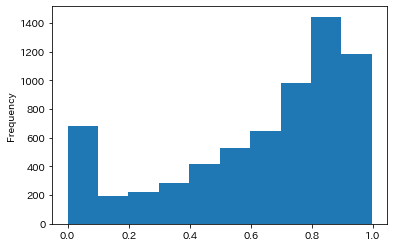

In [ ]:
oof["pred_prob"].plot(kind="hist")

In [ ]:
oof

,fold,y,pred_prob,pred_bool
id,,,,
0,2,1.0,0.770200,1.0
1,3,1.0,0.864915,1.0
2,10,1.0,0.602402,1.0
3,6,1.0,0.608250,1.0
4,9,0.0,0.846487,1.0
...,...,...,...,...
6581,7,1.0,0.074303,0.0
6582,4,0.0,0.029319,0.0
6583,4,0.0,0.106332,0.0


## 学習結果

In [ ]:
#特徴量の可視化
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現する.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(10, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='Blues_d', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    
    return fig, ax

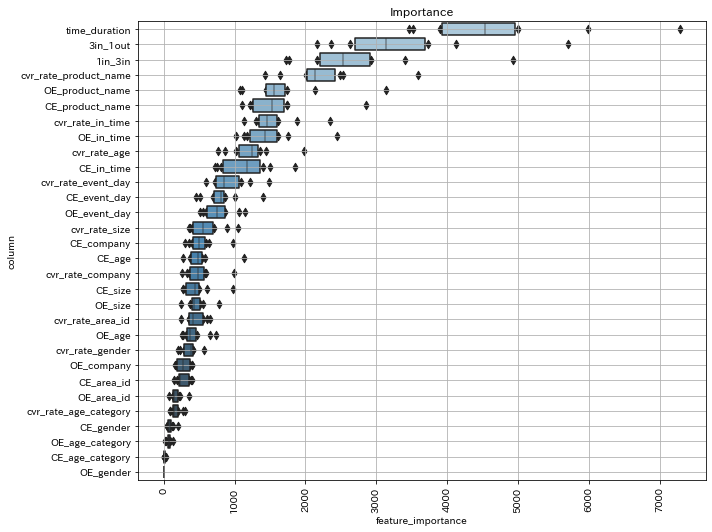

In [ ]:
fig, ax = visualize_importance(models, train_x)

In [ ]:
#ROCカーブの可視化
def visulalize_roc(df, fold):
    """各foldおよび出力平均のROCカーブを描画する

    args:
        df:出力oof df
        fold: fold数
    """
    
    fig = plt.figure(figsize=[8,8])
    
    tprs = []
    aucs = []
    
    mean_fpr = np.linspace(0,1,100)
    
    i = 1
    
    folds = list(range(1,fold+1))
    

    for v in folds:
        
        df_tmp = df[df.fold==v]
        fpr, tpr, t = roc_curve(df_tmp["y"], df_tmp["pred_prob"])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.3f)' % (i, roc_auc))
        i= i+1

    plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=r'Mean ROC (AUC = %0.3f )' % (mean_auc),lw=2, alpha=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")

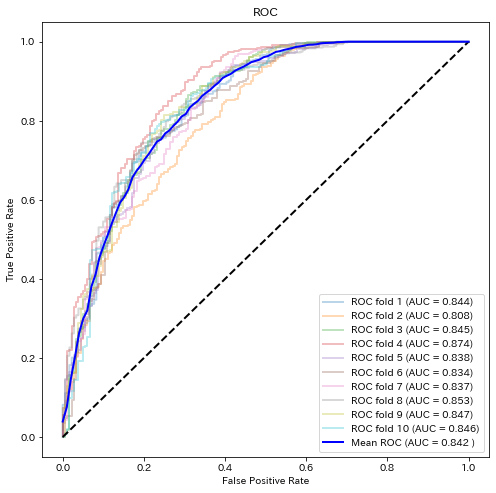

In [ ]:
visulalize_roc(oof,CONFIG.fold)

In [ ]:
#混合行列の可視化
def visualize_confusion_matrix(y_true,pred_label,height=.6,labels=None):
    
    """
    混合行列をプロットする
    """
    
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 4, size * 3))
    sns.heatmap(conf, cmap='Blues', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

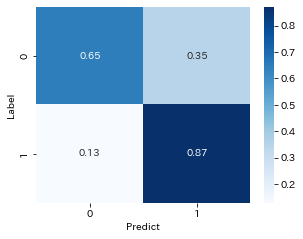

In [ ]:
visualize_confusion_matrix(y_true=oof.y,pred_label=oof.pred_bool)

## 予測

In [ ]:
df_index = df_test_encoded["customer_id"]
df_test_pred = df_test_encoded.iloc[:,1:]

pred = np.array([model.predict_proba(df_test_pred.values) for model in models])
pred = np.mean(pred, axis=0)[:, 1]
#pred = np.where(pred < 0.5, 0, 1)

In [ ]:
submission_pred = pd.DataFrame()
submission_pred["customer_id"] = df_index
submission_pred["buy_proba"] = pred

In [ ]:
submission_pred = submission_pred.groupby("customer_id").max()

In [ ]:
submission_pred

,buy_proba
customer_id,
20201026-010006,0.919200
20201026-010008,0.863020
20201026-010011,0.869246
20201026-010012,0.912069
20201026-010018,0.440234
...,...
20201101-120031,0.971625
20201101-120033,0.779080
20201101-120051,0.846796


In [ ]:
#submission_pred=submission_pred.groupby("customer_id").mean().reset_index()
#pred = np.where( submission_pred["buy_proba"].values<0.5, 0, 1)
#submission_pred["buy_proba"]=pred
#submission_pred=submission_pred.set_index("customer_id")

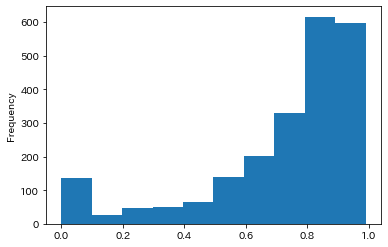

In [ ]:
submission_pred["buy_proba"].plot(kind="hist")

In [ ]:
submission_pred_0 = pd.DataFrame()
submission_pred_0["customer_id"] = df_test_0["customer_id"]
submission_pred_0["buy_proba"] = 0
submission_pred_0 = submission_pred_0.drop_duplicates()
submission_pred_0=submission_pred_0.set_index("customer_id")

others_list=set(list(submission_pred.index)) ^ set(list(submission_pred_0.index)) 
submission_pred_0 = submission_pred_0.loc[others_list]

In [ ]:
submission_pred_0

,buy_proba
customer_id,
20201029-050166,0
20201030-050234,0
20201027-020068,0
20201031-080117,0
20201101-050001,0
...,...
20201030-060194,0
20201101-080209,0
20201026-030165,0


In [ ]:
submission_pred_all = pd.concat([submission_pred,submission_pred_0],axis=0).reset_index().sort_values("customer_id").reset_index(drop=True)

In [ ]:
submission_pred_all

,customer_id,buy_proba
0,20201026-010006,0.919200
1,20201026-010008,0.863020
2,20201026-010011,0.869246
3,20201026-010012,0.912069
4,20201026-010018,0.440234
...,...,...
4525,20201101-120039,0.000000
4526,20201101-120046,0.000000
4527,20201101-120051,0.846796
4528,20201101-120052,0.815617


In [ ]:
submission_pred_all.buy_proba.value_counts()

0.000000    2326
0.895468       1
0.876793       1
0.961291       1
0.931956       1
            ... 
0.436470       1
0.925295       1
0.562858       1
0.883900       1
0.768672       1
Name: buy_proba, Length: 2205, dtype: int64

In [ ]:
submission_pred_all.to_csv(output_dir + CONFIG.exp+ "_submission.csv",index=False)